In [2]:
from MTCFeatures import MTCFeatureLoader
import numpy as np
from numpy.linalg import norm
from fractions import Fraction
import os
import subprocess
from matplotlib import pyplot as plt
import music21 as m21
m21.humdrum.spineParser.flavors['JRP'] = True

from score import getResolution, getOnsets, parseMelody

In [3]:
base40 = {
    0:"Cbb",
    1:"Cb",
    2:"C",
    3:"C#",
    4:"C##",
    5:"Dbbb",
    6:"Dbb",
    7:"Db",
    8:"D",
    9:"D#",
    10:"D##",
    11:"Ebbb",
    12:"Ebb",
    13:"Eb",
    14:"E",
    15:"E#",
    16:"E##",
    17:"Fbb",
    18:"Fb",
    19:"F",
    20:"F#",
    21:"F##",
    22:"unused",
    23:"Gbb",
    24:"Gb",
    25:"G",
    26:"G#",
    27:"G##",
    28:"Abbb",
    29:"Abb",
    30:"Ab",
    31:"A",
    32:"A#",
    33:"A##",
    34:"Bbbb",
    35:"Bbb",
    36:"Bb",
    37:"B",
    38:"B#",
    39:"B##",
}

In [4]:
def loadSong(songid, source="MTC-FS-INST-2.0"):
    fl = MTCFeatureLoader(source)
    id_list = [songid]
    sel_list = fl.applyFilter( ('inNLBIDs', id_list) )
    return next(sel_list)

def getSongLength(song):
    return len(song['features']['pitch'])

In [5]:
#computed onsets do not match onsets in MTC
class OnsetMismatchError(Exception):
    def __init__(self, arg):
        self.arg = arg
    def __str__(self):
        return repr(self.arg)

#Add syncope features:
#syncope (True if syncope)
#maxbeatstrength (max beatstrength DURING note)
#beatstrength_grid = beatstrength for each onsettick
def add_features(song, path_to_krn):
    s = parseMelody(os.path.join(path_to_krn, song['id']+'.krn'))
    unit = Fraction(1, getResolution(s)) #duration of a tick
    onsets = getOnsets(s)
    #check whether same onsets in songfeatures
    assert len(song['features']['onsettick']) == len(onsets)
    #NB. If initial rests (e.g. NLB142326_01) all onsets are shifted wrt MTC
    for ix in range(len(onsets)):
        if song['features']['onsettick'][ix] != onsets[ix] - onsets[0]:
            raise OnsetMismatchError("Onsets do not match.")
    beatstrength_grid = []
    s_onsets = m21.converter.parse(os.path.join(path_to_krn, song['id']+'.krn')) #original score
    for p in s_onsets.getElementsByClass(m21.stream.Part):
        for m in p.getElementsByClass(m21.stream.Measure):
            offset = 0*unit
            while offset < m.quarterLength:
                n = m21.note.Note("C").getGrace()
                m.insert(offset, n)
                beatstrength_grid.append(n.beatStrength)
                offset += unit
    assert beatstrength_grid[onsets[-1]] == song['features']['beatstrength'][-1]
    song['features']['syncope'] = [False] * len(song['features']['pitch'])
    song['features']['maxbeatstrength'] = [0.0] * len(song['features']['pitch'])
    song['features']['beatstrengthgrid'] = beatstrength_grid
    beatstrength_grid = np.array(beatstrength_grid)
    for ix, span in enumerate(zip(song['features']['onsettick'],song['features']['onsettick'][1:])):
        song['features']['maxbeatstrength'][ix] = song['features']['beatstrength'][ix]
        if np.max(beatstrength_grid[span[0]:span[1]]) > song['features']['beatstrength'][ix]:
            song['features']['syncope'][ix] = True
            song['features']['maxbeatstrength'][ix] = np.max(beatstrength_grid[span[0]:span[1]])
    #final note:
    song['features']['maxbeatstrength'][-1] = song['features']['beatstrength'][-1]



In [7]:
path_to_krn = '/Users/krane108/data/MTC/MTC-FS-INST-2.0/krn/'
song = loadSong('NLB147030_01', 'MTC-FS-INST-2.0')
add_features(song, path_to_krn)

OnsetMismatchError: 'Onsets do not match.'

In [16]:
#removeRepeats skips notes with repeated pitch (advise: set syncopes=True).
#if syncopes=True, take the highest metric weight DURING the span of the note. 
#if syncopes=False, take the metric weight at the onset time of the note.
#metric_weights is one of: 'beatstrength', 'ima', 'imaspect'

def computeWeightedPitch(song, removeRepeats=True, syncopes=False, metric_weights='beatstrength',):
    if metric_weights in ['ima', 'imaspect']:
        raise Exception(f'{metric_weights} not yet implemented.')
    
    onsettick = song['features']['onsettick']
    pitch40 = song['features']['pitch40']
    beatstrengthgrid = np.array(song['features']['beatstrengthgrid'])
    beatstrength = song['features']['beatstrength']

    song_length = getSongLength(song)
    ixs = []
    if removeRepeats:
        p_prev=-1
        for ix, p40 in enumerate(song['features']['pitch40']):
            if p40 != p_prev:
                ixs.append(ix)
            p_prev = p40
    else:
        ixs = list(range(song_length))

    weights = [beatstrength[ix] for ix in ixs]
    
    if syncopes:
        for ix, span in enumerate(zip(ixs, ixs[1:])):
            maxbeatstrength = np.max(beatstrengthgrid[onsettick[span[0]]:onsettick[span[1]]])
            weights[ix] = maxbeatstrength

    song['features']['weights'] = [0.0] * len(pitch40)
    for ix, songix in enumerate(ixs):
        song['features']['weights'][songix] = weights[ix]

    weightedpitch = np.zeros( (len(ixs), 40) )
    for ix, songix in enumerate(ixs):
        p = pitch40[songix]
        w = weights[ix]
        weightedpitch[ix, (p-1)%40] = w
    return weightedpitch, ixs


In [134]:
def getBeatinsongFloat(song, ixs):
    beatinsong_float = np.zeros( len(ixs) )
    for ix, song_ix in enumerate(ixs):
        beatinsong_float[ix] = float(Fraction(song['features']['beatinsong'][song_ix]))
    return beatinsong_float

#len_context_beat either float or tuple (length pre context, length post context) in beat units
#use_distance_weights either bool or tuple (use_distance_weights_pre, use_distance_weights_post)
#distance_weight_slope either float or tuple (distance_weight_slope_pre, distance_weight_slope_post)
#TODO if len_context_beat='auto', extend context to first note with higher metric weight (or equal if weight = 1.0)
#includeFocus is one of: 'none', 'pre', 'post', 'both' whether to include the focus note in the context
#if partialNotes, extend the PRE conext to the START of the first note within the context
def computePitchContext(
    song,
    weightedpitch,
    ixs, #indices of the notes (might skip repetition)
    len_context_beat=None,
    use_distance_weights=True,
    distance_weight_slope=1.0,
    use_metric_weights=True,
    includeFocus='none',
    partialNotes=True,
    normalize=False,
    epsilon=1e-4,
):    
    beatinsong = getBeatinsongFloat(song, ixs)
    songlength_beat = float(Fraction(song['features']['beatinsong'][-1])+Fraction(song['features']['beatfraction'][-1]))
    beatinsong_next = np.append(beatinsong[1:],songlength_beat)
    beatinsong_previous = np.insert(beatinsong[:-1],0, 0.0)

    if type(len_context_beat) == tuple:
        len_context_beat_pre = len_context_beat[0]
        len_context_beat_post = len_context_beat[1]
    elif len_context_beat == 'auto':
        print("Auto context length not yet implemented.")
    else:
        len_context_beat_pre = len_context_beat
        len_context_beat_post = len_context_beat
    len_context_beat = None

    if type(use_distance_weights) == tuple:
        use_distance_weights_pre = use_distance_weights[0]
        use_distance_weights_post = use_distance_weights[1]
    else:
        use_distance_weights_pre = use_distance_weights
        use_distance_weights_post = use_distance_weights
    use_distance_weights = None

    if type(distance_weight_slope) == tuple:
        distance_weight_slope_pre = distance_weight_slope[0]
        distance_weight_slope_post = distance_weight_slope[1]
    else:
        distance_weight_slope_pre = distance_weight_slope
        distance_weight_slope_post = distance_weight_slope
    distance_weight_slope = None

    #array to store the result
    pitchcontext = np.zeros( (len(ixs), 40 * 2) )

    contexts_pre = []
    contexts_post = []
    
    for ix, songix in enumerate(ixs):
        #compute offsets of all ohter notes
        beatoffset = beatinsong - beatinsong[ix]
        slicelength = beatinsong_next[ix] - beatinsong[ix]
        previous_slicelength = beatinsong[ix] - beatinsong_previous[ix]
        beatoffset_next = beatoffset - slicelength
        beatoffset_previous = beatoffset + previous_slicelength
        # print("noteix(song):", ixs[ix])
        # print()
        # print("beatinsong", beatinsong)
        # print("beatinsong_next", beatinsong_next)
        # print("beatoffset", beatoffset)
        # print("slicelength", slicelength)
        # print("beatoffset_next", beatoffset_next)
        #get context for each note
        #N.B. for some reason, np.where returns a tuple e.g: (array([], dtype=int64),)
        #for post, start context at END of focus note (anyway)
        if includeFocus in ['none', 'post']:
            context_pre = np.where(np.logical_and(beatoffset>=-(len_context_beat_pre + epsilon), beatoffset<0))[0]
        else: # ['both', 'pre']
            context_pre = np.where(np.logical_and(beatoffset>=-(len_context_beat_pre + epsilon), beatoffset<=0))[0]
        if includeFocus in ['none', 'pre']:
            #start context at END of note
            #do not include the note that starts AT the end of the context
            context_post = np.where(np.logical_and(beatoffset_next>=0, beatoffset_next<(len_context_beat_post - epsilon)))[0]
        else: # ['both', 'post']
            context_post = np.where(np.logical_and(beatoffset>=0, beatoffset_next<(len_context_beat_post - epsilon)))[0]        

        if partialNotes:
            if ix>0: #skip first, has no context_pre
                #check wether context start at beginning of a note. If not, add previous note
                #print(context_pre[0][0],beatoffset[context_pre[0][0]],len_context_beat)
                if context_pre.shape[0]>0:
                    if np.abs( beatoffset[context_pre[0]] + len_context_beat_pre ) > epsilon:
                        if context_pre[0]-1 >= 0:
                            context_pre = np.insert(context_pre, 0, context_pre[0]-1)
                else:
                    context_pre = np.insert(context_pre, 0, ix-1) #if context was empty, add previous note anyway

        contexts_pre.append(context_pre)
        contexts_post.append(context_post)

        #compute distance-weights
        if use_distance_weights_pre:
            distance_weights_pre  = beatoffset_previous[context_pre] * distance_weight_slope_pre/len_context_beat_pre + 1.0
            #set negative weights to zero:
            distance_weights_pre[distance_weights_pre<0.0] = 0.0
        else:
            distance_weights_pre  = np.ones((context_pre.shape))

        if use_distance_weights_post:
            distance_weights_post = beatoffset_next[context_post] * -distance_weight_slope_post/len_context_beat_post + 1.0
            #set negative weights to zero:
            distance_weights_post[distance_weights_post<0.0] = 0.0
        else:
            distance_weights_post = np.ones((context_post.shape))

        # print("ix", ix, ixs[ix])
        # print("length_context_pre", length_context_pre)
        # print("length_context_post", length_context_post)
        # print("distance_weights_pre", distance_weights_pre)
        # print("distance_weights_post", distance_weights_post)
        #combine context into one vector

        pitchcontext_pre  = np.dot(distance_weights_pre, weightedpitch[context_pre])
        pitchcontext_post = np.dot(distance_weights_post, weightedpitch[context_post])
        #normalize
        
        if not use_metric_weights:
            pitchcontext_pre[pitchcontext_pre>0] = 1.0
            pitchcontext_post[pitchcontext_post>0] = 1.0
        
        if normalize:
            pitchcontext_pre /= np.sum(np.abs(pitchcontext_pre),axis=0)
            pitchcontext_post /= np.sum(np.abs(pitchcontext_post),axis=0)
        
        #store result
        pitchcontext[ix,:40] = pitchcontext_pre
        pitchcontext[ix,40:] = pitchcontext_post

    return pitchcontext, contexts_pre, contexts_post


In [118]:
#find out how dissonant a note is in its context
#consonant:
# perfect prime : Dp = 0
# minor third : Dp = 11
# major third : Dp = 12
# perfect fourth : Dp = 17
# perfect fifth : Dp = 23
# minor sixth : Dp = 28
# major sixth : Dp = 29

def computeConsonance(
    song,
    pitchcontext,
    ixs,
    consonants40 = [0, 11, 12, 17, 23, 28, 29]
):
    song_length = len(ixs)

    consonants = np.zeros( (40,) )
    consonants[consonants40] = 1.0

    #store result
    consonance_pre = np.zeros( song_length )
    consonance_post = np.zeros( song_length )
    consonance_context = np.zeros( song_length )

    for ix, context in enumerate(pitchcontext):

        pitch40 = song['features']['pitch40'][ixs[ix]]-1

        #make copy of context
        context = np.copy(context)

        #normalize contexts: sum of context is 1.0
        context[:40] = context[:40] / np.sum(context[:40])
        context[40:] = context[40:] / np.sum(context[40:])

        intervals_pre  = np.roll(context[:40], -pitch40)
        intervals_post = np.roll(context[40:], -pitch40)

        consonance_pre[ix] = sum(np.multiply(intervals_pre, consonants))
        consonance_post[ix] = sum(np.multiply(intervals_post, consonants))

    #normalize
    #consonance_pre = consonance_pre / np.sum(consonance_pre)
    #consonance_post = consonance_post / np.sum(consonance_post)
    consonance_context = (consonance_pre + consonance_post) * 0.5

    return consonance_pre, consonance_post, consonance_context

In [97]:
def cosineSim(v1, v2):
    return np.dot(v1,v2)/(norm(v1)*norm(v2))

def normalizedCosineSim(v1, v2):
    return (1.0 + np.dot(v1,v2)/(norm(v1)*norm(v2))) / 2.0

def normalizedCosineDist(v1, v2):
    return 1.0-normalizedCosineSim(v1, v2)

def sseDist(v1, v2):
    return np.sum((v1-v2)**2)

In [72]:
def computeSelfSilimarity(song, pitchcontext):
    pass

In [73]:
def computeNovelty(song, pitchcontext, vectorDist=normalizedCosineDist):
    novelty = np.zeros( len(pitchcontext) )
    for ix in range(len(pitchcontext)):
        novelty[ix] = vectorDist(pitchcontext[ix,:40], pitchcontext[ix,40:])
    return novelty

In [74]:
def printReport(
    song,
    pitchcontext,
    contexts_pre,
    contexts_post,
    ixs,
    consonance_pre,
    consonance_post,
    consonance_context,
    novelty,
    note_ix=None
):
    for ix in range(len(pitchcontext)):
        if note_ix:
            if note_ix != ixs[ix]: continue
        pitchcontext_both = pitchcontext[:,:40] + pitchcontext[:,40:]
        pre_pitches = []
        post_pitches = []
        both_pitches = []
        for p in range(40):
            if pitchcontext[ix,p] > 0.0:
                pre_pitches.append((base40[p],pitchcontext[ix,p]))
        for p in range(40):
            if pitchcontext[ix,p+40] > 0.0:
                post_pitches.append((base40[p], pitchcontext[ix,p+40]))
        for p in range(40):
            if pitchcontext_both[ix,p] > 0.0:
                both_pitches.append((base40[p], pitchcontext_both[ix,p]))
        pre_pitches = [str(p) for p in sorted(pre_pitches, key=lambda x: x[1], reverse=True)]
        post_pitches = [str(p) for p in sorted(post_pitches, key=lambda x: x[1], reverse=True)]
        both_pitches = [str(p) for p in sorted(both_pitches, key=lambda x: x[1], reverse=True)]
        print("note", ixs[ix], "ix:", ix)
        print("  pitch:", song['features']['pitch'][ixs[ix]], song['features']['weights'][ixs[ix]])
        print("  context_pre:", contexts_pre[ix])
        print("  context_post:", contexts_post[ix])
        print("  pre:", "\n       ".join(pre_pitches))
        print("  post:", "\n        ".join(post_pitches))
        print("  both:", "\n        ".join(both_pitches))
        print("  consonance_pre    :", consonance_pre[ix])
        print("  consonance_post   :", consonance_post[ix])
        print("  consonance_context:", consonance_context[ix])
        print("  lbdm strength     :", song['features']['lbdm_boundarystrength'][ixs[ix]])
        print("  novelty           :", novelty[ix])
        print()

def plotArray(array, ixs):
    plt.figure(figsize=(14,5))
    plt.plot(array)
    plt.xticks(np.arange(0, len(ixs), 1), [str(i) for i in ixs])

In [41]:
path_to_krn = '/Users/krane108/data/MTC/MTC-FS-INST-2.0/krn/'
song = loadSong('NLB071395_01', 'MTC-FS-INST-2.0')
add_features(song, path_to_krn)

In [140]:
weightedpitch, ixs = computeWeightedPitch(
    song,
    removeRepeats=True,
    syncopes=True
)
pitchcontext, contexts_pre, contexts_post = computePitchContext(
    song,
    weightedpitch,
    ixs,
    len_context_beat=(3,0),
    partialNotes=True,
    use_distance_weights=(True,False),
    use_metric_weights=True,
    distance_weight_slope=1.0,
    includeFocus='both',
    normalize=False
)
consonance_pre, consonance_post, consonance_context = computeConsonance(song, pitchcontext, ixs)

In [141]:
consonance_context

array([1.        , 1.        , 0.73529412, 0.87894737, 0.78571429,
       0.875     , 0.78571429, 0.79661017, 0.84567901, 1.        ,
       0.88613861, 0.67123288, 0.87681159, 0.68656716, 0.93678161,
       0.78571429, 0.90384615, 0.67567568, 0.93333333, 0.81443299,
       0.86363636, 0.92857143, 0.73913043, 1.        , 0.90123457,
       0.78461538, 0.84126984, 0.86144578, 1.        , 0.90666667,
       0.84756098, 0.8       , 0.81451613, 0.84756098, 1.        ,
       0.83928571, 0.74647887, 0.8902439 , 1.        , 0.82113821,
       0.83333333, 0.89830508, 0.92622951, 1.        , 0.96710526,
       1.        , 0.69565217, 0.94827586, 0.95876289, 0.96212121,
       0.85119048, 0.80246914, 0.76      , 0.87323944, 0.76428571,
       0.85204082, 0.95731707, 1.        , 1.        , 1.        ,
       0.68181818, 0.94886364, 0.95876289, 0.96212121, 0.85119048,
       0.80246914, 0.76      , 0.87323944, 0.76428571, 0.85204082])

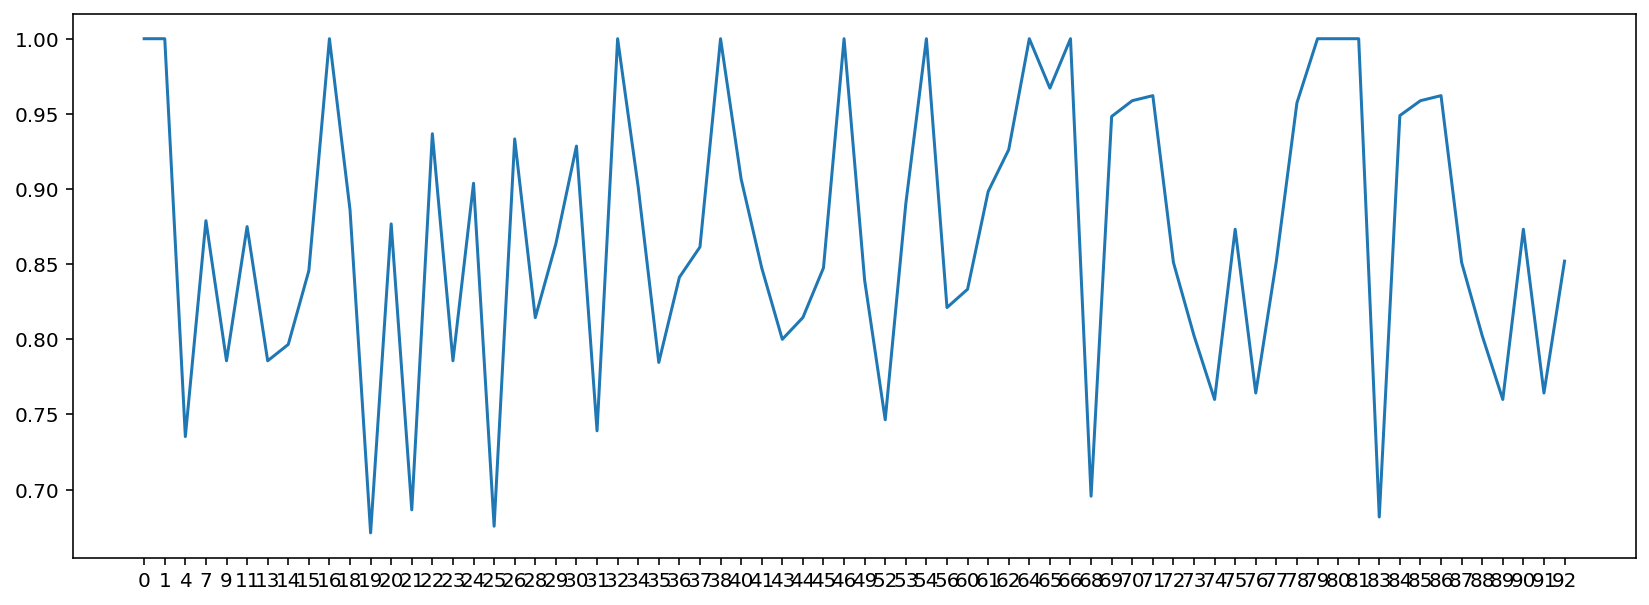

In [142]:
plotArray(consonance_context, ixs)

In [143]:
diss_ixs = np.where(consonance_context<np.nanpercentile(consonance_context,25))[0]
print([ixs[int(ix)] for ix in diss_ixs])

[4, 9, 13, 14, 19, 21, 23, 25, 31, 35, 43, 52, 68, 74, 76, 83, 89, 91]


In [144]:
printReport(
    song,
    pitchcontext,
    contexts_pre,
    contexts_post,
    ixs,
    consonance_pre,
    consonance_post,
    consonance_context,
    novelty,
    note_ix=None
)

note 0 ix: 0
  pitch: D4 0.25
  context_pre: [0]
  context_post: [0]
  pre: ('D', 0.2222222222222222)
  post: ('D', 0.25)
  both: ('D', 0.4722222222222222)
  consonance_pre    : 1.0
  consonance_post   : 1.0
  consonance_context: 1.0
  lbdm strength     : None
  novelty           : 0.3408913326608497

note 1 ix: 1
  pitch: G4 1.0
  context_pre: [0 1]
  context_post: [1]
  pre: ('G', 1.1111111111111112)
       ('D', 0.25)
  post: ('G', 1.0)
  both: ('G', 2.111111111111111)
        ('D', 0.25)
  consonance_pre    : 1.0
  consonance_post   : 1.0
  consonance_context: 1.0
  lbdm strength     : 0.0
  novelty           : 0.09706135633101942

note 4 ix: 2
  pitch: F#4 0.5
  context_pre: [0 1 2]
  context_post: [2]
  pre: ('G', 1.0)
       ('F#', 0.6666666666666666)
       ('D', 0.22222222222222224)
  post: ('F#', 0.5)
  both: ('F#', 1.1666666666666665)
        ('G', 1.0)
        ('D', 0.22222222222222224)
  consonance_pre    : 0.47058823529411764
  consonance_post   : 1.0
  consonance_context

In [145]:
#colordict. keys are colors, values are lists of indices of notes with that color
#e.g. {'red':[6, 12, 19, 20, 23]}
def getColoredScore(song, path_to_krn, colordict):
    s = parseMelody(os.path.join(path_to_krn, song['id']+'.krn'))
    #check for right length #if so, assume notes correspond with features
    assert len(song['features']['pitch']) == len(s.flat.notes)
    for color, ixs in colordict.items():
        for ix in ixs:
            s.flat.notes[int(ix)].style.color = color
    return s


In [146]:
#for repeated pitches:
#spans would be better for ixs [(start,end),(start,end),...]
def getColoredIxs(diss_ixs, ixs, songlength):
    colorixs = []
    for ix in diss_ixs:
        colorixs.append(ix)
        temp_ix = ix+1
        while (not temp_ix in ixs) and (temp_ix < songlength):
            colorixs.append(temp_ix)
            temp_ix += 1
    return colorixs

In [18]:
#get all nlbids in x/y
fl = MTCFeatureLoader('MTC-FS-INST-2.0')
fl.registerFilter('withmeter', lambda y: lambda x: x['features']['timesignature'][0] == y )
seq_iter = fl.applyFilter(('withmeter', '2/2'))
seq_iter = fl.randomSel(50,  seq_iter=seq_iter)
songs = list(seq_iter)

In [70]:
def repairLyline(line):
    line = line.replace("\\override Stem.color","\\once\\override Stem.color")
    line = line.replace("\\override NoteHead.color","\\once\\override NoteHead.color")
    line = line.replace("\\include \"lilypond-book-preamble.ly\"","")
    return line
#we need to repair lily generated by m21 concerning color
#\override Stem.color -> \once\override Stem.color
#\override NoteHead.color -> \once\override NoteHead.color
def repairLy(filename):
    with open(filename,'r') as f:
        lines = [repairLyline(l) for l in f.readlines()]
    lines = lines + [ f'\paper {{ tagline = "{filename}" }}']
    with open(filename,'w') as f:
        f.writelines(lines)

In [71]:
path_to_krn = '/Users/krane108/data/MTC/MTC-FS-INST-2.0/krn/'
outputpath = '/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/'
for song in songs:
    print(song['id'])
    try:
        add_features(song, path_to_krn)
    except OnsetMismatchError as e:
        print(song['id'], ": Onset mismatch with MTCFeatures")
        continue
    
    weightedpitch, ixs = computeWeightedPitch(
        song,
        removeRepeats=True,
        syncopes=True
    )

    pitchcontext, contexts_pre, contexts_post = computePitchContext(
        song,
        weightedpitch,
        ixs,
        4,
        partialNotes=True,
        use_distance_weights=True,
        distance_weight_slope=1.0,
        includeFocus='both',
        normalize=False
    )

    consonance_pre, consonance_post, consonance_context = computeConsonance(song, pitchcontext, ixs)    
    
    ixsnp = np.array(ixs)
    diss_ixs = ixsnp[np.where(consonance_context<np.nanpercentile(consonance_context,40))]
    color_ixs = getColoredIxs(diss_ixs, ixs, len(song['features']['pitch']))
    s = getColoredScore(song, path_to_krn, {'grey':color_ixs})
    s.write('lily', outputpath+song['id']+'.ly')
    repairLy(outputpath+song['id']+'.ly')
    subprocess.run(["lilypond", outputpath+song['id']+'.ly'], cwd=outputpath)
subprocess.run(["rm all.pdf"], cwd=outputpath, shell=True)
subprocess.run(["pdftk *.pdf cat output all.pdf"], cwd=outputpath, shell=True)
    

NLB147030_01
NLB147030_01 : Onset mismatch with MTCFeatures
NLB196355_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB196355_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB196355_01.pdf'...
Success: compilation successfully completed


NLB178028_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB178028_01.ly'
Parsing...
Interpreting music...[8][16][24][32]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB178028_01.pdf'...
Success: compilation successfully completed


NLB186121_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB186121_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB186121_01.pdf'...
Success: compilation successfully completed


NLB151003_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB151003_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB151003_01.pdf'...
Success: compilation successfully completed


NLB180343_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB180343_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB180343_01.pdf'...
Success: compilation successfully completed


NLB130097_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB130097_01.ly'
Parsing...
Interpreting music...
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB130097_01.ly:21:14: warning: conflict with event: `key-change-event'
             
             \key f \major 
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB130097_01.ly:22:14: warning: discarding event: `key-change-event'
             
             \key d \minor 
[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB130097_01.pdf'...
Success: compilation successfully completed


NLB009131_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB009131_01.ly'
Parsing...
Interpreting music...[8][16][24][32]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB009131_01.pdf'...
Success: compilation successfully completed


NLB134780_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB134780_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB134780_01.pdf'...
Success: compilation successfully completed


NLB177483_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB177483_01.ly'
Parsing...
Interpreting music...[8][16][24][32]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB177483_01.pdf'...
Success: compilation successfully completed


NLB150750_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB150750_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB150750_01.pdf'...
Success: compilation successfully completed


NLB190527_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB190527_01.ly'
Parsing...
Interpreting music...[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB190527_01.pdf'...
Success: compilation successfully completed


NLB009050_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB009050_01.ly'
Parsing...
Interpreting music...[8][16][24][32][40][48][56][56]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB009050_01.pdf'...
Success: compilation successfully completed


NLB191153_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB191153_01.ly'
Parsing...
Interpreting music...[8][8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB191153_01.pdf'...
Success: compilation successfully completed


NLB075388_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB075388_01.ly'
Parsing...
Interpreting music...[8][16][24][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB075388_01.pdf'...
Success: compilation successfully completed


NLB134705_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB134705_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB134705_01.pdf'...
Success: compilation successfully completed


NLB177434_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB177434_01.ly'
Parsing...
Interpreting music...
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB177434_01.ly:21:14: warning: conflict with event: `key-change-event'
             
             \key c \major 
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB177434_01.ly:22:14: warning: discarding event: `key-change-event'
             
             \key a \minor 
[8][16][24][32]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB177434_01.pdf'...
Success: compilation successfully completed


NLB145150_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB145150_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB145150_01.pdf'...
Success: compilation successfully completed


NLB183432_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB183432_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB183432_01.pdf'...
Success: compilation successfully completed


NLB197986_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB197986_01.ly'
Parsing...
Interpreting music...[8][16][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB197986_01.pdf'...
Success: compilation successfully completed


NLB150140_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB150140_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB150140_01.pdf'...
Success: compilation successfully completed


NLB122595_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB122595_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB122595_01.pdf'...
Success: compilation successfully completed


NLB167365_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB167365_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB167365_01.pdf'...
Success: compilation successfully completed


NLB148758_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB148758_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB148758_01.pdf'...
Success: compilation successfully completed


NLB195347_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB195347_01.ly'
Parsing...
Interpreting music...[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB195347_01.pdf'...
Success: compilation successfully completed


NLB151002_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB151002_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB151002_01.pdf'...
Success: compilation successfully completed


NLB130016_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB130016_01.ly'
Parsing...
Interpreting music...
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB130016_01.ly:21:14: warning: conflict with event: `key-change-event'
             
             \key d \major 
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB130016_01.ly:22:14: warning: discarding event: `key-change-event'
             
             \key b \minor 
[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB130016_01.pdf'...
Success: compilation successfully completed


NLB073202_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB073202_01.ly'
Parsing...
Interpreting music...
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB073202_01.ly:21:14: warning: conflict with event: `key-change-event'
             
             \key bes \major 
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB073202_01.ly:22:14: warning: discarding event: `key-change-event'
             
             \key g \minor 
[8][8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB073202_01.pdf'...
Success: compilation successfully completed


NLB125182_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB125182_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB125182_01.pdf'...
Success: compilation successfully completed


NLB180663_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB180663_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB180663_01.pdf'...
Success: compilation successfully completed


NLB196469_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB196469_01.ly'
Parsing...
Interpreting music...
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB196469_01.ly:21:14: warning: conflict with event: `key-change-event'
             
             \key c \major 
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB196469_01.ly:22:14: warning: discarding event: `key-change-event'
             
             \key a \minor 
[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB196469_01.pdf'...
Success: compilation successfully completed


NLB135811_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB135811_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB135811_01.pdf'...
Success: compilation successfully completed


NLB116215_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB116215_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB116215_01.pdf'...
Success: compilation successfully completed


NLB152244_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB152244_01.ly'
Parsing...
Interpreting music...[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB152244_01.pdf'...
Success: compilation successfully completed


NLB198191_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB198191_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB198191_01.pdf'...
Success: compilation successfully completed


NLB177419_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB177419_01.ly'
Parsing...
Interpreting music...[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB177419_01.pdf'...
Success: compilation successfully completed


NLB004790_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB004790_01.ly'
Parsing...
Interpreting music...[8][16][24][32][40][48][48]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 or 2 pages...
Drawing systems...
Converting to `NLB004790_01.pdf'...
Success: compilation successfully completed


NLB009095_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB009095_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB009095_01.pdf'...
Success: compilation successfully completed


NLB182845_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB182845_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB182845_01.pdf'...
Success: compilation successfully completed


NLB195363_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB195363_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB195363_01.pdf'...
Success: compilation successfully completed


NLB129882_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB129882_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB129882_01.pdf'...
Success: compilation successfully completed


NLB135828_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB135828_01.ly'
Parsing...
Interpreting music...[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB135828_01.pdf'...
Success: compilation successfully completed


NLB002966_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB002966_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB002966_01.pdf'...
Success: compilation successfully completed


NLB138467_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB138467_01.ly'
Parsing...
Interpreting music...
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB138467_01.ly:20:14: warning: conflict with event: `key-change-event'
             
             \key g \major 
/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB138467_01.ly:21:14: warning: discarding event: `key-change-event'
             
             \key e \minor 
[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB138467_01.pdf'...
Success: compilation successfully completed


NLB074069_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB074069_01.ly'
Parsing...
Interpreting music...[8]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB074069_01.pdf'...
Success: compilation successfully completed


NLB125147_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB125147_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB125147_01.pdf'...
Success: compilation successfully completed


NLB196680_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB196680_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB196680_01.pdf'...
Success: compilation successfully completed


NLB150120_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB150120_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB150120_01.pdf'...
Success: compilation successfully completed


NLB177155_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB177155_01.ly'
Parsing...
Interpreting music...[8][16]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB177155_01.pdf'...
Success: compilation successfully completed


NLB129752_01


Fontconfig warning: ignoring UTF-8: not a valid region tag
Processing `/Users/krane108/git/polifonia-project/tunes-code/output/diss_2-2_20221107/NLB129752_01.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Finding the ideal number of pages...
Fitting music on 1 page...
Drawing systems...
Converting to `NLB129752_01.pdf'...
Success: compilation successfully completed
rm: all.pdf: No such file or directory


CompletedProcess(args=['pdftk *.pdf cat output all.pdf'], returncode=0)